<a href="https://colab.research.google.com/github/barronh/pykpp/blob/master/examples/ZombieApocalypse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zombie Apocalypse

    author: Barron H. Henderson
    date: 2020-02-11

Inspired by numerous mathematics examples using Zombies (e.g., [1,2,3]), this is a test of the pykpp system to solve for a zombie outbreak. 

The basic model is that zombies (Z) both kill and infect humans (H), and humans kill zombies. I have also added a natural death and birth rate for humans, though it makes little difference on the time scales here. I have made adidtional assumptions as follows:

1. uniform distribution of humans and zombies,
2. interactions are proportional to density,
3. like infectous diseases, the zombie infection rates increase in winter
4. human militarization against zombies increases with the total zombie population.



[1] https://people.maths.ox.ac.uk/maini/PKM%20publications/384.pdf

[2] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4798798/

[3] https://www.amazon.com/dp/0691173206/ref=cm_sw_em_r_mt_dp_688KKQ5HMHJW9G6Z6654 

## Install the Python-based Kinetic Pre-processor

* If on a system where you are not admin, add `--user` after install (i.e., `pip install --user ...`)

In [7]:
!pip install https://github.com/barronh/pykpp/archive/master.zip

     / 491kB 3.6MB/s
  Created wheel for pykpp: filename=pykpp-1.0rc0-cp36-none-any.whl size=128251 sha256=9859ce9674b595d4a8b0cf6910836df11257271240f842c90b857867fef47244
  Stored in directory: /tmp/pip-ephem-wheel-cache-0h3j48x_/wheels/19/f5/4c/ec3ae33968d410bd59e9e411399b8cc7d64fdb7282752581cf
Successfully built pykpp


In [1]:
import io
import pykpp
import pandas as pd
import numpy as np
import matplotlib as mpl


plt = mpl.pyplot


## Reactions

* R1 : Zombies infect humans with a seasonal variation
  * k_inf is set later as a constant
  * A multiplier ranging from 0.25 in the summer to 1.75 in the winter
* R2 : zombies kill humans using a constant coefficient
* R3 : humans kill zombies using a coefficient made of two parts:
  * k_hkillz : humans naturally defend themselves killing zombies
  * Z * AREA : the military or police gets involved proportional to the total zombie population.
  * Right now, human militarization increase with zombie population, but it decreases immediately in response. This is unrealistic. It would be good to add a "memory" so that the zombies are removed more effectively.
* R4, R5 : humans naturally procreate and die


In [2]:
mechanism = """
#EQUATIONS
{R1} Zombie + Human = 2 Zombie + Infected : k_inf * (np.cos(np.radians(t / 365 * 360)) * 0.5 + 1); {infections increase in winter}
{R2} Zombie + Human = Zombie + KilledHuman : k_zkillh;
{R3} Zombie + Human = Human + KilledZombie : k_hkillz * (Zombie * AREA); {humans militarize against zombies proportional to total zombie population}
{R4} Human = 2 Human : k_hbirth;
{R5} Human = DeadHuman : k_hdeath;

"""

## Initialize the model

* time (t) is initialized at the start
* the end is set to 10 years hences
* Latitude/Longitude/Temperature/M are unused, but added to satisfy exectations of pykpp
* AREA is set to USA area in km2
* constant rate coefficients are set
* monitoring the Human and Zombie population
* using the scipy.ode integrator
* Finally setting the initial values
  * CFACTOR is used to convert populations to population/km2
  * Humans (H) is set to an approximate USA population
  * Zombies (Z) is set to a very small initial population

In [3]:
setup = """
#INLINE PY_INIT
t=TSTART=0 # days
TEND=365.25*10+TSTART
TEMP = 288.; # unused
M = 0.; # unused
DT = 3/24.
StartDate = 'datetime(2010, 7, 14)'
Latitude_Degrees = 40. # Unused
Longitude_Degrees = 0.00E+00 # Unused
AREA = 9.834e6 {USA area in km2}
k_inf = 0.5/365 # 0.5 km2/person/year
k_zkillh = 0.2/365 # 0.2 km2/person/year
k_hkillz = 0.1/365 # 0.1 km2/person/year
k_hbirth = 0.01/365 # 1% per year
k_hdeath = 0.01/365 # 1% per year
#ENDINLINE
"""
config = """
#MONITOR Human; Zombie;
#INTEGRATOR odeint;
"""
init = """
#INITVALUES
CFACTOR = 1./AREA {people-to-people/km2 based on USA area}
ALL_SPEC=1e-32*CFACTOR;
Human = 300e6 {approximate US population}
Zombie = 10
"""
mechdef = setup + '\n' + config + '\n' + init + '\n' + mechanism

## Load the model

* Using IO to create an in-memory file
* Creating a mechanism:
  * called 'zombies', so the output will be 'zombies.pykpp.tsv'
  * solving at a 1 day increment
  * monitoring as it is solved per year

In [4]:
mech = pykpp.mech.Mech(
    io.StringIO(mechdef), mechname='zombies', incr=1, monitor_incr=365, verbose=0
)

Species: 6 
Reactions: 5


## Reset and Run

* Run the model and print the total time to solve

In [5]:
runtime = mech.run(verbose=1, debug=False, solver='odeint'); # or 'vode' or 'lsoda'
#runtime = mech.run(verbose=1, debug=False, solver='lsoda',  max_order_ns=2,  max_order_s=2, max_step=1);
print('Runtime (s)', runtime)

tstart:  0
tend:  3652.5
dt:  0.125
solver_keywords:  {}
{t:0,Human:3E+08,Zombie:10}
odeint {'atol': 0.001, 'rtol': 0.0001, 'mxstep': 1000, 'hmax': 0.125, 'mxords': 2, 'mxordn': 2}
{t:365,Human:3E+08,Zombie:7.3}
{t:730,Human:3E+08,Zombie:7.3}
{t:1095,Human:3E+08,Zombie:7.3}
{t:1460,Human:3E+08,Zombie:7.3}
{t:1826,Human:3E+08,Zombie:7.3}
{t:2191,Human:3E+08,Zombie:7.3}
{t:2556,Human:3E+08,Zombie:7.3}
{t:2921,Human:3E+08,Zombie:7.3}
{t:3286,Human:3E+08,Zombie:7.3}
{t:3651,Human:3E+08,Zombie:7.3}
Runtime (s) 9.885945320129395


## Plot the Zombie Statistics

* Using pandas to read the file
* Using matplotlib for control over plotting.
* note that the seasonality of infection rate causes the wobble.

In [6]:
def zombieplot(tsvpath, timelabel='Years'):
  data = pd.read_csv(tsvpath, delimiter='\t', index_col='t')
  if timelabel.lower() == 'years':
    tfac = 1 / 365.25
  elif timelabel.lower() == 'days':
    tfac = 1
  else:
    raise KeyError(f'timelabel must be Years or Days; got {timelabel}')

  t = data.index.values * tfac
  kH = data.Human / 1e6
  Z = data.Zombie
  dZ = data.KilledZombie
  kI = data.Infected
  fig, axx = plt.subplots(1, 3, figsize=(14, 4), gridspec_kw=dict(wspace=0.2, left=.2))
  plt.setp(axx, xlabel=timelabel)
  plt.rc('lines', marker='o', linestyle='none', markersize=1)
  axx[0].plot(t, kH, label='Human Population (1e6)')
  axx[0].yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter('{0:.5f}'.format))
  axx[1].plot(t, Z, label='Zombies Population')
  axx[2].plot(t[1:], np.diff(dZ), label='Zombies Killed Rate (per day)')
  axx[2].plot(t[1:], np.diff(kI), label='Infection Rate (per day)')
  for ai, ax in enumerate(axx):
    ax.legend()
  axx[1].set_ylim(0, None);
  axx[2].set_ylim(0, None);
  return fig

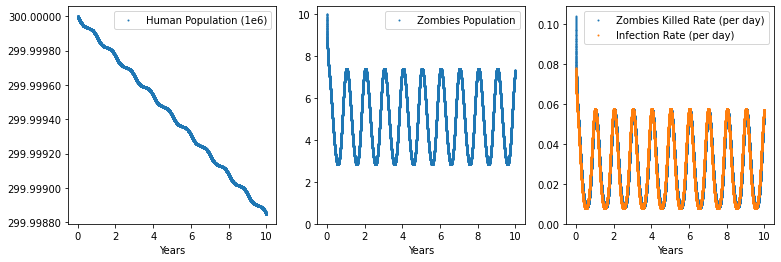

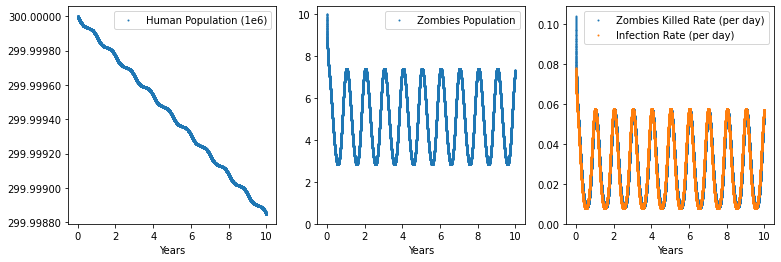

In [7]:
zombieplot('zombies.pykpp.tsv')

## Re run with adjustments parameters

In [8]:
mech = pykpp.mech.Mech(
    io.StringIO(mechdef), mechname='zombies2', incr=1, monitor_incr=365, verbose=0
)
mech.world['Zombie'] *= 2
mech.world['k_inf'] *= 20
#runtime = mech.run(verbose=1, debug=False, solver='lsoda',  max_order_ns=2,  max_order_s=2, max_step=0.01);
runtime = mech.run(verbose=1, debug=False, solver='odeint'); # or 'vode' or 'lsoda'

Species: 6 
Reactions: 5
tstart:  0
tend:  3652.5
dt:  0.125
solver_keywords:  {}
{t:0,Human:3E+08,Zombie:20}
odeint {'atol': 0.001, 'rtol': 0.0001, 'mxstep': 1000, 'hmax': 0.125, 'mxords': 2, 'mxordn': 2}
{t:365,Human:3E+08,Zombie:1.5E+02}
{t:730,Human:3E+08,Zombie:1.5E+02}
{t:1095,Human:3E+08,Zombie:1.5E+02}
{t:1460,Human:3E+08,Zombie:1.5E+02}
{t:1826,Human:3E+08,Zombie:1.5E+02}
{t:2191,Human:3E+08,Zombie:1.5E+02}
{t:2556,Human:3E+08,Zombie:1.5E+02}
{t:2921,Human:3E+08,Zombie:1.5E+02}
{t:3286,Human:3E+08,Zombie:1.5E+02}
{t:3651,Human:3E+08,Zombie:1.5E+02}


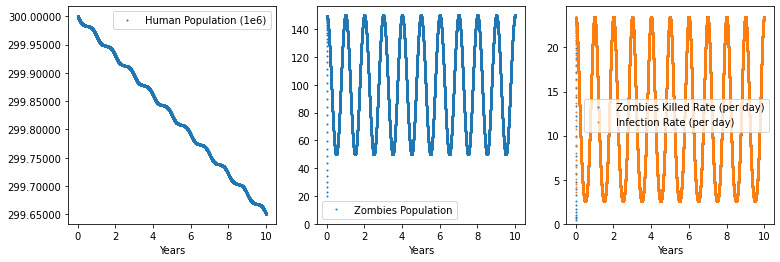

In [12]:
zombieplot('zombies2.pykpp.tsv');

# Equations of the End: Teaching Mathematical Modeling Using the Zombie Apocalypse

Lofgren et al. 2016[1] published a teaching example and an on-line playground[2] with solutions. This offers a really cool opportunity to check our results. 

We get the exact same results -- hooray! Try changing the parameters. For example, adjust the parameters to represent COVID. Consider adding effects of temperature and humidity in transmission.

[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4798798/#s1-jmbe-17-134

[2] http://cartwrig.ht/apps/whitezed/

In [13]:
import pykpp
import pandas as pd
zeddef = """
#EQUATIONS
{R1} Zombie + Susceptible = Zombie + Infected : k_inf;
{R2} Zombie + Susceptible = Zombie + KilledHuman : k_zkillh;
{R3} Zombie + Susceptible = Susceptible + KilledZombie : k_hkillz; 
{R5} Zombie = DecayedZombie : k_zdeath;
{R6} Susceptible = Vaccinated : k_vaccination;
{R7} Infected = Zombie : k_incubation;

#INLINE PY_INIT
t=TSTART=0 # days
TEND=TSTART + 60
TEMP = 288.; # unused, but represents average surface temperature
P = 101325.; # unused, but represents average surface pressure
M = P / 8.314 / TEMP * 6.022e23; # unused

DT = 1/24.

StartDate = 'datetime(2010, 7, 14)'
Latitude_Degrees = 40. # Unused
Longitude_Degrees = 0.00E+00 # Unused

k_inf = 1.          {infection rate}
k_zkillh = 0.0      {zombie kill human rate}
k_hkillz = 0.0      {human kill zombie rate}
k_zdeath = 0.0      {zombie decay}
k_vaccination = 0.0 {rate of susceptible vaccination}
incubation_time_days = 1e-3 {must be greater than zero}
k_incubation = 1 / (incubation_time_days) { tau = 1 / k; so tau = 1 seconds}
#ENDINLINE

#MONITOR Susceptible; Vaccinated; Zombie;
#INTEGRATOR odeint;

#INITVALUES
CFACTOR = 1./10001 { denominator should match sum of people = Susceptible + Vaccinated + Zombie}
ALL_SPEC=1e-32*CFACTOR;
Susceptible = 10000
Vaccinated = 0
Zombie = 1
"""
mech = pykpp.mech.Mech(
    io.StringIO(zeddef), mechname='zed', incr=1/24, monitor_incr=5, verbose=0
)
runtime = mech.run(verbose=1, debug=False, solver='odeint'); # or 'vode' or 'lsoda'

Species: 7 
Reactions: 6
tstart:  0
tend:  60
dt:  0.041666666666666664
solver_keywords:  {}
{t:0,Susceptible:1E+04,Vaccinated:0,Zombie:1}
odeint {'atol': 0.001, 'rtol': 0.0001, 'mxstep': 1000, 'hmax': 0.041666666666666664, 'mxords': 2, 'mxordn': 2}
{t:5,Susceptible:9.9E+03,Vaccinated:0,Zombie:1.5E+02}
{t:10,Susceptible:3.1E+03,Vaccinated:0,Zombie:6.9E+03}
{t:15,Susceptible:30,Vaccinated:0,Zombie:1E+04}
{t:20,Susceptible:0.22,Vaccinated:0,Zombie:1E+04}
{t:25,Susceptible:0.0016,Vaccinated:0,Zombie:1E+04}
{t:30,Susceptible:1.1E-05,Vaccinated:0,Zombie:1E+04}
{t:35,Susceptible:8.3E-08,Vaccinated:0,Zombie:1E+04}
{t:40,Susceptible:5.8E-10,Vaccinated:0,Zombie:1E+04}
{t:45,Susceptible:4E-12,Vaccinated:0,Zombie:1E+04}
{t:50,Susceptible:2.9E-14,Vaccinated:0,Zombie:1E+04}
{t:55,Susceptible:2E-16,Vaccinated:0,Zombie:1E+04}


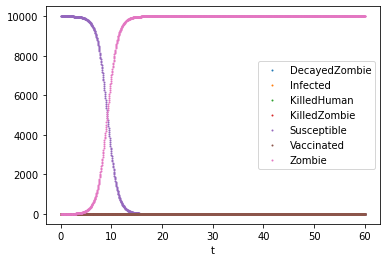

In [19]:
data = pd.read_csv('zed.pykpp.tsv', delimiter='\t', index_col='t')
data.drop(['TEMP', 'P', 'CFACTOR'], axis=1).plot();

In [20]:
data.columns

Index(['CFACTOR', 'TEMP', 'P', 'DecayedZombie', 'Infected', 'KilledHuman',
       'KilledZombie', 'Susceptible', 'Vaccinated', 'Zombie'],
      dtype='object')